# Import req libraries

In [20]:
import pandas as pd
import glob
import datetime
from matplotlib import pyplot as plt
import tabula as tb

# Dolar histórico

In [21]:
# Search for "dolar histórico" in a website
dolar_historico = pd.read_html('http://estudiodelamo.com/cotizacion-historica-dolar-peso-argentina/')

# dolar_historico from pandas method read_html will be a list with several dataframes.
# We want to keep the 2nd element of the list, which is the desired df
dolar_blue_df = dolar_historico[1]

dolar_blue_df.tail()

,Unnamed: 0,Variación anual dólar informal (según último mes del año),ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SEP,OCT,NOV,DIC
7,2018,"103,92%","$19,55","$19,95","$20,36","$20,60","$25,17","$28,40","$27,45","$36,00","$39,30","$34,50","$36,00","$38,50"
8,2019,"90,91%","$35,50","$38,80","$42,65","$45,00","$44,50","$42,30","$43,70","$60,00","$58,25","$66,00","$66,25","$73,50"
9,2020,"117,69%","$74,00","$74,50","$78,50","$108,00","$115,00","$116,00","$131,00","$131,00","$140,00","$163,00","$149,00","$160,00"
10,2021,"27,50%","$148,00","$141,00","$136,00","$145,00","$152,00","$163,00","$175,50","$176,50","$182,00","$193,50","$197,50","$204,00"
11,2022,"61,47%","$209,00","$207,00","$196,00","$196,50","$201,00","$234,00","$286,00","$285,00",NaN,NaN,NaN,NaN


In [22]:
# Create column names for dolar_blue_df, fix dtypes and drop null values

cols = ['Year', 'drop', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
dolar_blue_df.columns = cols
dolar_blue_df.drop(columns='drop', inplace=True)
dolar_blue_df.Year = dolar_blue_df.Year.astype(str)

# Melt df to unpivot df from wide to long format

dolar_blue_df = dolar_blue_df.melt(id_vars='Year', var_name='Month', value_name='exchange_rate')
dolar_blue_df.dropna(inplace=True)

# Fix $xxx,yy format to xxx.yy where x,y = numbers

dolar_blue_df['exchange_rate'] = dolar_blue_df['exchange_rate'].apply(lambda x: float(x[1:].replace(',','.')))

# Check it's not missing latest values

dolar_blue_df[dolar_blue_df['Year'] == '2022'].head()

,Year,Month,exchange_rate
11,2022,01,209.0
23,2022,02,207.0
35,2022,03,196.0
47,2022,04,196.5
59,2022,05,201.0


# Salary files

In [23]:
files_list = glob.glob("recibos/*.pdf")
payroll_list = [tb.read_pdf_with_template(
                file
                , pages='1'
                , template_path='recibo-short-table.json') for file in files_list]

# payroll_list will return a list of dataframes
# payroll_list[i][0]['Fecha liquidación'] = 'dd-mm-yy'
# payroll_list[i][0]['Categoría'][3] = 'xxx,yy'

salary_df = pd.DataFrame({'Year' : [payroll_list[i][0]['Fecha liquidación'][1][-4:] for i, v in enumerate(payroll_list)]
                , 'Month': [payroll_list[i][0]['Fecha liquidación'][1][3:5] for i, v in enumerate(payroll_list)]
                , 'Salary_ARS' : [float(payroll_list[i][0]['Categoría'][3][-10:-3])*1000 for i, v in enumerate(payroll_list)]}
                , index=[i for i, v in enumerate(payroll_list)])

salary_df.head()

,Year,Month,Salary_ARS
0,2022,01,158053.0
1,2022,02,151622.0
2,2022,03,145775.0
3,2022,04,162730.0
4,2022,05,176336.0


##### Merge 'salary_df' and 'dolar_blue_df' into one 'df'

In [24]:
df = pd.merge(left=salary_df, right=dolar_blue_df, on=['Year', 'Month'], how='left')
df.head()

,Year,Month,Salary_ARS,exchange_rate
0,2022,01,158053.0,209.0
1,2022,02,151622.0,207.0
2,2022,03,145775.0,196.0
3,2022,04,162730.0,196.5
4,2022,05,176336.0,201.0


In [25]:
new_date_format='%Y%m'
old_date_format='%Y%m'
col = "fecha"

df["YearMonth"] = df['Year'] + df['Month']
df["YearMonth"] = pd.to_datetime(df["YearMonth"], format=old_date_format).dt.strftime(new_date_format)

df.head()

,Year,Month,Salary_ARS,exchange_rate,YearMonth
0,2022,01,158053.0,209.0,202201
1,2022,02,151622.0,207.0,202202
2,2022,03,145775.0,196.0,202203
3,2022,04,162730.0,196.5,202204
4,2022,05,176336.0,201.0,202205


Working on the USD Salary and adjustement for inflation

In [26]:
df['Salary_USD'] = df['Salary_ARS']/df['exchange_rate']

df = df.sort_values(by='YearMonth', ascending=True)

monthly_working_hours = 160

df['Hourly_rate'] = df['Salary_USD']/monthly_working_hours

df.head()

,Year,Month,Salary_ARS,exchange_rate,YearMonth,Salary_USD,Hourly_rate
8,2021,09,113926.0,182.0,202109,625.967033,3.912294
10,2021,10,126254.0,193.5,202110,652.475452,4.077972
11,2021,11,120992.0,197.5,202111,612.617722,3.828861
12,2021,12,120992.0,204.0,202112,593.098039,3.706863
0,2022,01,158053.0,209.0,202201,756.234450,4.726465


##### Create inflation df

In [27]:
inflation_df = pd.read_excel('https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_aperturas.xls', header=5, nrows=3, index_col='Región GBA')
inflation_df.dropna(inplace=True)
inflation_df = inflation_df.transpose()
inflation_df = inflation_df.reset_index()
inflation_df.columns = ['Date', 'Inflation_pct']
new_date_format='%Y%m'
old_date_format='%Y-%m-%d'

inflation_df["YearMonth"] = pd.to_datetime(inflation_df["Date"], format=old_date_format).dt.strftime(new_date_format)
inflation_df = inflation_df[['YearMonth', 'Inflation_pct']]
inflation_df.head()

,YearMonth,Inflation_pct
0,201701,1.3
1,201702,2.5
2,201703,2.4
3,201704,2.6
4,201705,1.3


In [28]:
df = df.merge(inflation_df, on='YearMonth')

# Calculate accumulated
acumular = 0
inflation_accumulated = []
for index, row in df.iterrows():
    acumular+=row['Inflation_pct']
    inflation_accumulated.append(acumular)

inflation_accumulated = [round(i/100,3) for i in inflation_accumulated]

df['Inflation_accum'] = inflation_accumulated

df.head()

,Year,Month,Salary_ARS,exchange_rate,YearMonth,Salary_USD,Hourly_rate,Inflation_pct,Inflation_accum
0,2021,09,113926.0,182.0,202109,625.967033,3.912294,3.8,0.038
1,2021,10,126254.0,193.5,202110,652.475452,4.077972,3.8,0.076
2,2021,11,120992.0,197.5,202111,612.617722,3.828861,2.3,0.099
3,2021,12,120992.0,204.0,202112,593.098039,3.706863,4.1,0.140
4,2022,01,158053.0,209.0,202201,756.234450,4.726465,3.9,0.179


In [29]:
df['Salary_ARS_Real'] = round(df['Salary_ARS']/(1 + df['Inflation_accum']),0)

df.head()

,Year,Month,Salary_ARS,exchange_rate,YearMonth,Salary_USD,Hourly_rate,Inflation_pct,Inflation_accum,Salary_ARS_Real
0,2021,09,113926.0,182.0,202109,625.967033,3.912294,3.8,0.038,109755.0
1,2021,10,126254.0,193.5,202110,652.475452,4.077972,3.8,0.076,117336.0
2,2021,11,120992.0,197.5,202111,612.617722,3.828861,2.3,0.099,110093.0
3,2021,12,120992.0,204.0,202112,593.098039,3.706863,4.1,0.140,106133.0
4,2022,01,158053.0,209.0,202201,756.234450,4.726465,3.9,0.179,134057.0


Plot and export:
---
* USD salary evolution plot
* Salary adjusted for inflation plot
* Dataframe

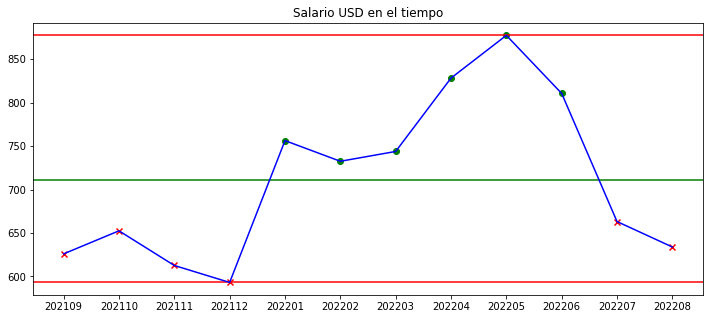

In [30]:
plt.figure(figsize=(12,5))
plt.title("Salario USD en el tiempo")
plt.axhline(y=df['Salary_USD'].min(), color='r', linestyle='-')
plt.axhline(y=df['Salary_USD'].max(), color='r', linestyle='-')
plt.axhline(y=df['Salary_USD'].mean(), color='g', linestyle='-')

x = df['YearMonth']
y = df['Salary_USD']

mark0 = [(row['YearMonth'], row['Salary_USD']) for index, row in df.iterrows() if row['Salary_USD'] <= df['Salary_USD'].mean()]

x0 = [i[0] for i in mark0]
y0 = [i[1] for i in mark0]

mark1 = [(row['YearMonth'], row['Salary_USD']) for index, row in df.iterrows() if row['Salary_USD'] > df['Salary_USD'].mean()]

x1 = [i[0] for i in mark1]
y1 = [i[1] for i in mark1]

plt.plot(x, y, color='blue')
plt.scatter(x0, y0, marker='x', color='r')
plt.scatter(x1, y1, marker='o', color='g')

plt.savefig('report/salary_usd.jpeg')
plt.show()

Plot Salary adjusted for Inflation

fig saved


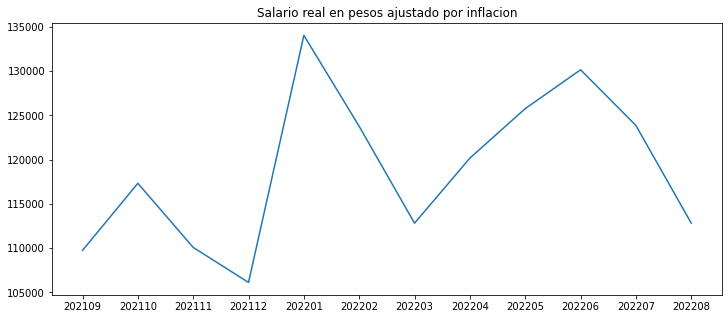

In [31]:
plt.figure(figsize=(12,5))
plt.title("Salario real en pesos ajustado por inflacion")
plt.plot('YearMonth', 'Salary_ARS_Real', data=df)

if (len(glob.glob('/report/salary_ars_adjusted_for_inflation.jpeg')) == 0):
    plt.savefig('report/salary_ars_adjusted_for_inflation.jpeg')
    print('fig saved')

In [32]:
df = df.sort_values('YearMonth')
df.to_csv('report/salary_analysis.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'report/salary_analysis.csv'